In [41]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from IPython.display import Video
import imageio
import os

In [42]:
ENV_NAME = "Acrobot-v1"
PATH = f'Models/DQN/{ENV_NAME}/'
MODEL_FILE = os.path.join(PATH, ENV_NAME + ".pth")
EVAL_VIDEO_FILE = os.path.join(PATH, f'{ENV_NAME}_eval_video.mp4')
PLOT_TRAINING = False
os.makedirs(PATH, exist_ok=True)

In [43]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
# Get number of actions + observations from gym action space
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

In [44]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [45]:
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)
device

device(type='mps')

In [46]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# Create a Queue that will store each S,A,S,R 
class ReplayMemory(object):

    # make a queue 
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    # Puts S,A,S,R on the queue (FIFO)
    def push(self, *args):
        self.memory.append(Transition(*args))

    # Select random entries
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    # get the length of our memory
    def __len__(self):
        return len(self.memory)

In [47]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__() 

        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        out = F.relu(self.layer1(x))
        out = F.relu(self.layer2(out))
        return self.layer3(out) 


# Setup Training Varaibles + Algo

In [48]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000) # this must always be greater than the batch size

In [49]:
# Epsilon-greedy policy: balances exploration and exploitation
steps_done = 0

def eps_greedy(state):
    global steps_done
    sample = random.random()

    # Calculate epsilon: decreases over time to explore less
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        # Exploitation: choose the best action
        with torch.no_grad():
            return policy_net(state).argmax(dim=1).view(1, 1)
    else:
        # Exploration: choose a random action
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


In [50]:
# List to store the duration of each episode
episode_durations = []

def plot_durations(show_result=False):
    # Create or select the figure for plotting
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    
    # Set the title based on whether it's the final result or ongoing training
    if show_result:
        plt.title('Result')
    else:
        plt.clf()  # Clear the current figure for live updates
        plt.title('Training...')
    
    # Label the axes and plot the episode durations
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    # Plot the 100-episode running average for smoother trends
    if len(durations_t) >= 100:
        # Calculate the running average using a sliding window of 100 episodes
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        # Pad the beginning with zeros to align with the episode timeline
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    # Briefly pause to allow the plot to update in real-time
    plt.pause(0.001)
    
    # Handle interactive display for Jupyter Notebooks (if applicable)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)  # Clear the output for live updates
        else:
            display.display(plt.gcf())  # Display the final result


In [51]:
def optimize_model():
    # Exit if there aren't enough samples
    if len(memory) < BATCH_SIZE:
        return

    # Sample a batch of transitions and unpack into separate batches
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Prepare batches for states, actions, rewards, and non-final next states
    non_final_mask = torch.tensor([s is not None for s in batch.next_state], device=device, dtype=torch.bool) # tells us if end state or not
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Calculate Q-values for current states and actions
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Calculate expected Q-values for next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # this is the predicted "target" or estimated ground truth goodness of the state action pair we are looking at 
    expected_state_action_values = reward_batch + (GAMMA * next_state_values)

    # Compute loss and update model (we want the policy network to basically predict the estimated goodness, so we just take the error between the current output and the estimated ground truth)
    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


# Train Model

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode : 0 | Duration: 500 | Total Reward : -500.0
Episode : 1 | Duration: 500 | Total Reward : -500.0
Episode : 2 | Duration: 365 | Total Reward : -364.0
Episode : 3 | Duration: 427 | Total Reward : -426.0
Episode : 4 | Duration: 500 | Total Reward : -500.0
Episode : 5 | Duration: 500 | Total Reward : -500.0
Episode : 6 | Duration: 500 | Total Reward : -500.0
Episode : 7 | Duration: 500 | Total Reward : -500.0
Episode : 8 | Duration: 500 | Total Reward : -500.0
Episode : 9 | Duration: 500 | Total Reward : -500.0
Episode : 10 | Duration: 500 | Total Reward : -500.0
Episode : 11 | Duration: 500 | Total Reward : -500.0
Episode : 12 | Duration: 500 | Total Reward : -500.0
Episode : 13 | Duration: 500 | Total Reward : -500.0
Episode : 14 | Duration: 481 | Total Reward : -480.0
Episode : 15 | Duration: 424 | Total Reward : -423.0
Episode : 16 | Duration: 500 | Total Reward : -500.0
Episode : 17 | Duration: 358 | Total Reward : -357.0
Episode : 18 | Duration: 253 | Total Reward : -252.0
Epi

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode : 100 | Duration: 92 | Total Reward : -91.0
Episode : 101 | Duration: 196 | Total Reward : -195.0
Episode : 102 | Duration: 229 | Total Reward : -228.0
Episode : 103 | Duration: 85 | Total Reward : -84.0
Episode : 104 | Duration: 115 | Total Reward : -114.0
Episode : 105 | Duration: 126 | Total Reward : -125.0
Episode : 106 | Duration: 334 | Total Reward : -333.0
Episode : 107 | Duration: 84 | Total Reward : -83.0
Episode : 108 | Duration: 219 | Total Reward : -218.0
Episode : 109 | Duration: 90 | Total Reward : -89.0
Episode : 110 | Duration: 93 | Total Reward : -92.0
Episode : 111 | Duration: 355 | Total Reward : -354.0
Episode : 112 | Duration: 80 | Total Reward : -79.0
Episode : 113 | Duration: 99 | Total Reward : -98.0
Episode : 114 | Duration: 273 | Total Reward : -272.0
Episode : 115 | Duration: 92 | Total Reward : -91.0
Episode : 116 | Duration: 93 | Total Reward : -92.0
Episode : 117 | Duration: 121 | Total Reward : -120.0
Episode : 118 | Duration: 102 | Total Reward :

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode : 200 | Duration: 104 | Total Reward : -103.0
Episode : 201 | Duration: 97 | Total Reward : -96.0
Episode : 202 | Duration: 138 | Total Reward : -137.0
Episode : 203 | Duration: 80 | Total Reward : -79.0
Episode : 204 | Duration: 93 | Total Reward : -92.0
Episode : 205 | Duration: 101 | Total Reward : -100.0
Episode : 206 | Duration: 96 | Total Reward : -95.0
Episode : 207 | Duration: 85 | Total Reward : -84.0
Episode : 208 | Duration: 80 | Total Reward : -79.0
Episode : 209 | Duration: 80 | Total Reward : -79.0
Episode : 210 | Duration: 85 | Total Reward : -84.0
Episode : 211 | Duration: 84 | Total Reward : -83.0
Episode : 212 | Duration: 92 | Total Reward : -91.0
Episode : 213 | Duration: 244 | Total Reward : -243.0
Episode : 214 | Duration: 232 | Total Reward : -231.0
Episode : 215 | Duration: 93 | Total Reward : -92.0
Episode : 216 | Duration: 176 | Total Reward : -175.0
Episode : 217 | Duration: 95 | Total Reward : -94.0
Episode : 218 | Duration: 111 | Total Reward : -110.

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode : 300 | Duration: 83 | Total Reward : -82.0
Episode : 301 | Duration: 97 | Total Reward : -96.0
Episode : 302 | Duration: 97 | Total Reward : -96.0
Episode : 303 | Duration: 79 | Total Reward : -78.0
Episode : 304 | Duration: 92 | Total Reward : -91.0
Episode : 305 | Duration: 101 | Total Reward : -100.0
Episode : 306 | Duration: 112 | Total Reward : -111.0
Episode : 307 | Duration: 90 | Total Reward : -89.0
Episode : 308 | Duration: 96 | Total Reward : -95.0
Episode : 309 | Duration: 110 | Total Reward : -109.0
Episode : 310 | Duration: 84 | Total Reward : -83.0
Episode : 311 | Duration: 105 | Total Reward : -104.0
Episode : 312 | Duration: 79 | Total Reward : -78.0
Episode : 313 | Duration: 91 | Total Reward : -90.0
Episode : 314 | Duration: 114 | Total Reward : -113.0
Episode : 315 | Duration: 115 | Total Reward : -114.0
Episode : 316 | Duration: 124 | Total Reward : -123.0
Episode : 317 | Duration: 119 | Total Reward : -118.0
Episode : 318 | Duration: 104 | Total Reward : -

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode : 400 | Duration: 82 | Total Reward : -81.0
Episode : 401 | Duration: 94 | Total Reward : -93.0
Episode : 402 | Duration: 119 | Total Reward : -118.0
Episode : 403 | Duration: 101 | Total Reward : -100.0
Episode : 404 | Duration: 88 | Total Reward : -87.0
Episode : 405 | Duration: 87 | Total Reward : -86.0
Episode : 406 | Duration: 126 | Total Reward : -125.0
Episode : 407 | Duration: 88 | Total Reward : -87.0
Episode : 408 | Duration: 105 | Total Reward : -104.0
Episode : 409 | Duration: 94 | Total Reward : -93.0
Episode : 410 | Duration: 90 | Total Reward : -89.0
Episode : 411 | Duration: 119 | Total Reward : -118.0
Episode : 412 | Duration: 94 | Total Reward : -93.0
Episode : 413 | Duration: 75 | Total Reward : -74.0
Episode : 414 | Duration: 102 | Total Reward : -101.0
Episode : 415 | Duration: 107 | Total Reward : -106.0
Episode : 416 | Duration: 87 | Total Reward : -86.0
Episode : 417 | Duration: 74 | Total Reward : -73.0
Episode : 418 | Duration: 188 | Total Reward : -18

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode : 500 | Duration: 99 | Total Reward : -98.0
Episode : 501 | Duration: 83 | Total Reward : -82.0
Episode : 502 | Duration: 110 | Total Reward : -109.0
Episode : 503 | Duration: 79 | Total Reward : -78.0
Episode : 504 | Duration: 102 | Total Reward : -101.0
Episode : 505 | Duration: 85 | Total Reward : -84.0
Episode : 506 | Duration: 103 | Total Reward : -102.0
Episode : 507 | Duration: 84 | Total Reward : -83.0
Episode : 508 | Duration: 115 | Total Reward : -114.0
Episode : 509 | Duration: 130 | Total Reward : -129.0
Episode : 510 | Duration: 113 | Total Reward : -112.0
Episode : 511 | Duration: 89 | Total Reward : -88.0
Episode : 512 | Duration: 150 | Total Reward : -149.0
Episode : 513 | Duration: 91 | Total Reward : -90.0
Episode : 514 | Duration: 124 | Total Reward : -123.0
Episode : 515 | Duration: 106 | Total Reward : -105.0
Episode : 516 | Duration: 86 | Total Reward : -85.0
Episode : 517 | Duration: 163 | Total Reward : -162.0
Episode : 518 | Duration: 203 | Total Reward

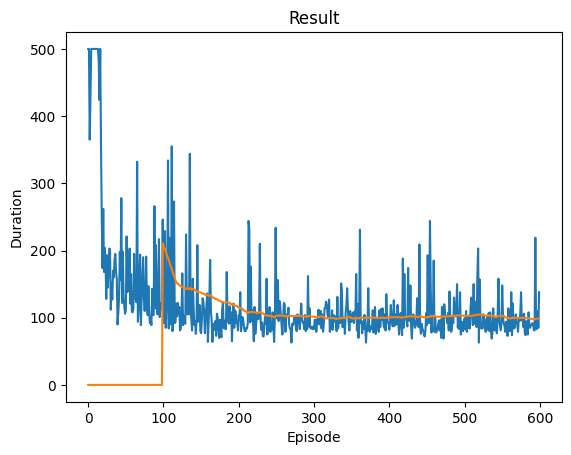

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [52]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    total_reward = 0 

    if i_episode % 100 == 0:
        frames = []

    for t in count():
        action = eps_greedy(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if i_episode % 100 == 0:
            frames.append(env.render())

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            if  PLOT_TRAINING:
                plot_durations()
            else:
                print(f"Episode : {i_episode} | Duration: {t + 1} | Total Reward : {total_reward}")
            break
    
    if len(frames) > 0:
        video_path = os.path.join(PATH, f'{ENV_NAME}_train_video_ep_{i_episode}.mp4')
        imageio.mimsave(video_path, frames, fps=20)
        frames = []

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

# Save Model

In [53]:
torch.save(policy_net.state_dict(), MODEL_FILE)
policy_net.eval()  # Set the model to evaluation mode

DQN(
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
)

# Load Model

In [54]:
# Assuming `model` is your model class
model = DQN(n_observations, n_actions)  # Reinstantiate the model
model.load_state_dict(torch.load(MODEL_FILE))
model.to(device)
model.eval()  # Set the model to evaluation mode

/var/folders/tn/2w8rrhcd1pg6dh6_lfl7w3mm0000gn/T/ipykernel_43831/2372278560.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_FILE))

DQN(
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
)

# Test The Model

In [55]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
env.reset()
frames = []

# Initialize the environment and get its state
state, info = env.reset()

for i_episode in range(1000):

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = model(state).argmax(dim=1).view(1, 1)
    observation, reward, terminated, truncated, _ = env.step(action.item())

    if terminated or truncated:
        print(f"Episode ended after {i_episode+1} steps")
        break

    frames.append(env.render())
    state = observation

env.close()

imageio.mimsave(EVAL_VIDEO_FILE, frames, fps=20)
Video(EVAL_VIDEO_FILE, embed=True) # Display the video in Jupyter Notebook

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (500, 500) to (512, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode ended after 92 steps
